In [54]:
from MovieBookAnalysis import *
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from copy import deepcopy

In [2]:
IMDB_ratings = pd.read_csv('movie_books_IMDB_ratings.csv', index_col=0)

In [3]:
GR_ratings = pd.read_csv('movie_books_GR_ratings.csv', index_col=0)

In [4]:
MC_ratings = pd.read_csv('movie_books_MC_ratings.csv', index_col=0)

In [5]:
dummies = pd.get_dummies(IMDB_ratings.MPAArating)
IMDB_ratings = pd.concat([IMDB_ratings, dummies], axis=1)
IMDB_ratings = IMDB_ratings.rename(columns = {'PG-13':'PG13'})

In [6]:
all_df = IMDB_ratings.merge(GR_ratings, on='Title').merge(MC_ratings, on='Title')

In [7]:
all_df.head()

,Title,MPAArating,Runtime,IMDBRating,IMDBRatingCount,IMDBMCRating,IMDBMCRatingCount,APPROVED,G,GP,...,PG13,R,UNRATED,X,GRRating,GRRatingCount,MCUserRating,MCUserRatingCount,MCCriticRating,MCCriticRatingCount
0,The Godfather,R,175,9.2,1092395,100,14,0,0,0,...,0,1,0,0,4.34,232195,9.1,1771,100,14
1,The Godfather: Part II,R,202,9.0,742660,80,10,0,0,0,...,0,1,0,0,4.50,4,9.1,465,80,10
2,Fight Club,R,139,8.9,1264505,66,35,0,0,0,...,0,1,0,0,4.19,330661,9.0,1238,66,35
3,The Lord of the Rings: The Return of the King,PG-13,201,8.9,1146982,94,41,0,0,0,...,1,0,0,0,4.16,82,9.0,2444,94,41
4,The Lord of the Rings: The Fellowship of the Ring,PG-13,178,8.8,1171348,92,34,0,0,0,...,1,0,0,0,4.55,75,9.0,1608,92,34


In [8]:
all_df['logGRRating'] = np.log(all_df.GRRating)
all_df['squareIMDBRatingCount'] = np.square(all_df.IMDBRatingCount)

In [9]:
all_df.head()

,Title,MPAArating,Runtime,IMDBRating,IMDBRatingCount,IMDBMCRating,IMDBMCRatingCount,APPROVED,G,GP,...,UNRATED,X,GRRating,GRRatingCount,MCUserRating,MCUserRatingCount,MCCriticRating,MCCriticRatingCount,logGRRating,squareIMDBRatingCount
0,The Godfather,R,175,9.2,1092395,100,14,0,0,0,...,0,0,4.34,232195,9.1,1771,100,14,1.467874,1193326836025
1,The Godfather: Part II,R,202,9.0,742660,80,10,0,0,0,...,0,0,4.50,4,9.1,465,80,10,1.504077,551543875600
2,Fight Club,R,139,8.9,1264505,66,35,0,0,0,...,0,0,4.19,330661,9.0,1238,66,35,1.432701,1598972895025
3,The Lord of the Rings: The Return of the King,PG-13,201,8.9,1146982,94,41,0,0,0,...,0,0,4.16,82,9.0,2444,94,41,1.425515,1315567708324
4,The Lord of the Rings: The Fellowship of the Ring,PG-13,178,8.8,1171348,92,34,0,0,0,...,0,0,4.55,75,9.0,1608,92,34,1.515127,1372056137104


In [10]:
def avgMSEForLinReg(df, IV, DVs, k=10):
    MSE_list = []
    
    var_list = DVs
    var_list.insert(0, IV)
    tempDF = df[var_list].dropna()
    
    for x in range(k):
        y_train, y_test, X_train, X_test = train_test_split(tempDF[IV], tempDF[DVs], test_size=0.2)

        model = LinearRegression(normalize=True)
        model.fit(X_train, y_train)

        MSE = np.mean((model.predict(X_test)-y_test)**2)
        MSE_list.append(MSE)
        
    return np.mean(MSE_list)

In [127]:
def CrossValidateForMSEAtDiffLambda(df, IV, DVs):
    
    avgMSELasso_values = []
    avgMSERidge_values = []
    avgMSELinReg_values = []
    avgR2Lasso_values = []
    avgR2Ridge_values = []
    avgR2LinReg_values = []
    
    
    lmda_values = [x*0.005 for x in range(1, 1001)]
    #lmda_values = [x*0.00005 for x in range(1, 11)]
    
    var_list = deepcopy(DVs)
    var_list.insert(0, IV)
    tempDF = df[var_list].dropna()
    
    for lmda in lmda_values:
        MSELasso_list = []
        MSERidge_list = []
        MSELinReg_list = []
        R2Lasso_list = []
        R2Ridge_list = []
        R2LinReg_list = []
        
        for x in range(10):
            y_train, y_test, X_train, X_test  = train_test_split(tempDF[IV], tempDF[DVs], test_size=0.2)
            
            #print(X_train.shape,X_test.shape, y_train.shape, y_test.shape)
            #print(train_test_split(tempDF[IV], tempDF[DVs], test_size=0.2))
            
            model = Lasso(alpha=lmda, normalize=True)
            model2 = Ridge(alpha=lmda, normalize=True)
            model3 = LinearRegression(normalize=True)
            model.fit(X_train, y_train)
            model2.fit(X_train, y_train)
            model3.fit(X_train, y_train)
            #print(model.score(X_test, y_test), model2.score(X_test, y_test))
            MSELasso = np.mean((model.predict(X_test)-y_test)**2)
            MSELasso_list.append(MSELasso)
            MSERidge = np.mean((model2.predict(X_test)-y_test)**2)
            MSERidge_list.append(MSERidge)
            MSELinReg = np.mean((model3.predict(X_test)-y_test)**2)
            MSELinReg_list.append(MSELinReg)
            R2Lasso_list.append(model.score(X_test, y_test))
            R2Ridge_list.append(model2.score(X_test, y_test))
            R2LinReg_list.append(model3.score(X_test, y_test))
            #print(X_test, y_test)
            
            
        avgMSELasso_values.append(np.mean(MSELasso_list))
        avgMSERidge_values.append(np.mean(MSERidge_list))
        avgMSELinReg_values.append(np.mean(MSELinReg_list))
        avgR2Lasso_values.append(np.mean(R2Lasso_list))
        avgR2Ridge_values.append(np.mean(R2Ridge_list))
        avgR2LinReg_values.append(np.mean(R2LinReg_list))
        
    minMSE1 = min(avgMSELasso_values)
    idx = avgMSELasso_values.index(minMSE1)
    minLmda = lmda_values[idx]
    LassoAvgR2 = avgR2Lasso_values[idx]
    
    minMSE2 = min(avgMSERidge_values)
    idx2 = avgMSERidge_values.index(minMSE2)
    minLmda2 = lmda_values[idx2]
    RidgeAvgR2 = avgR2Ridge_values[idx2]
    
    LinRegAvgR2 = np.mean(avgR2LinReg_values)

    y_train, y_test, X_train, X_test = train_test_split(tempDF[IV], tempDF[DVs], test_size=0.2)
    model1 = Lasso(alpha=minLmda, normalize=True)
    model1.fit(X_train, y_train)
    model2 = Ridge(alpha=minLmda2, normalize=True)
    model2.fit(X_train, y_train)
    model3 = LinearRegression(normalize=True)
    model3.fit(X_train, y_train)

        
        
    
    print(minLmda, minMSE1, model1.coef_, model1.intercept_, np.mean(avgR2Lasso_values))
    print(minLmda2, minMSE2, model2.coef_, model2.intercept_, np.mean(avgR2Ridge_values))
    print(model3.coef_, model3.intercept_, np.mean(avgR2LinReg_values))
        
    return lmda_values, avgMSELasso_values, avgMSERidge_values, avgMSELinReg_values, avgR2Lasso_values, avgR2Ridge_values, avgR2LinReg_values 

In [128]:
def plotMSEandR2vLambda(df, IV, DVs):
    lmda_values, avgMSELasso_values, avgMSERidge_values, avgMSELinReg_values, avgR2Lasso_values, avgR2Ridge_values, avgR2LinReg_values  = CrossValidateForMSEAtDiffLambda(df, IV, DVs)
    
    fig, axarr = plt.subplots(6, sharex=True)
    fig.set_size_inches(10, 7, forward=True)
    
    axarr[0].plot(lmda_values, avgMSELasso_values)
    axarr[0].set_title('Average MSE for k = 10 at different Lambda Values (Lasso)')
    #axarr[0].set_xlabel('Lambda')
    axarr[0].set_ylabel('Avg Test MSE')
    
    axarr[1].plot(lmda_values, avgMSERidge_values)
    axarr[1].set_title('Average MSE for k = 10 at different Lambda Values (Ridge)')
    #axarr[1].set_xlabel('Lambda')
    axarr[1].set_ylabel('Avg Test MSE')
    
    axarr[2].plot(lmda_values, avgMSELinReg_values)
    axarr[2].set_title('Average MSE for k = 10 at different Lambda Values (LinReg)')
    #axarr[2].set_xlabel('Lambda')
    axarr[2].set_ylabel('Avg Test MSE')
    
    axarr[3].plot(lmda_values, avgR2Lasso_values)
    axarr[3].set_title('Average R2 for k = 10 at different Lambda Values (Lasso)')
    #axarr[3].set_xlabel('Lambda')
    axarr[3].set_ylabel('Avg Test R2')
    
    axarr[4].plot(lmda_values, avgR2Ridge_values)
    axarr[4].set_title('Average R2 for k = 10 at different Lambda Values (Ridge)')
    #axarr[4].set_xlabel('Lambda')
    axarr[4].set_ylabel('Avg Test R2')
    
    axarr[5].plot(lmda_values, avgR2LinReg_values)
    axarr[5].set_title('Average R2 for k = 10 at different Lambda Values (LinReg)')
    axarr[5].set_xlabel('Lambda')
    axarr[5].set_ylabel('Avg Test R2')
    

0.005 0.0378133529903 [  0.00000000e+00   0.00000000e+00   4.80274026e-13   0.00000000e+00
   1.32154453e-02] 8.03207647967 -0.0829302998897
0.765 0.0329530852036 [  2.84623135e-02   1.81201828e-07   2.35740994e-13   5.97621040e-04
   1.16966508e-01] 7.52105655211 0.252685270507
[  5.84209438e-02  -1.86844527e-07   7.28353013e-13   3.07899789e-04
   1.40151927e-01] 7.47413119641 0.333568967625


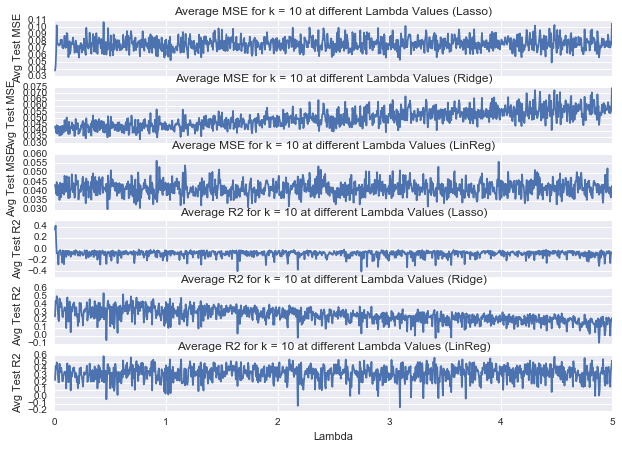

In [129]:
plotMSEandR2vLambda(all_df, 'IMDBRating', ['R', 'IMDBRatingCount', 'squareIMDBRatingCount', 'Runtime', 'GRRating'])

In [ ]:
plotMSEvLambda(all_df, 'IMDBRating', ['logGRRating', 'R', 'IMDBRatingCount'])

In [ ]:
plotMSEvLambda(all_df, 'IMDBRating', ['IMDBRatingCount', 'squareIMDBRatingCount'])

In [ ]:
avgMSEForLinReg(all_df, 'IMDBRating', ['IMDBRatingCount', 'squareIMDBRatingCount'], 10)